# YouTube QoE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intrig-unicamp/hackathon5G/blob/main/datasets/youtube-qoe.ipynb)

Esse Notebook contém uma breve análise dos dados que o YouTube coleta para telemetria dos seus clientes (Web Desktop, Web Mobile, IFrame API, App). Os participantes são encorajados a experimentar com os dados para descobrir padrões, formas de resolver problemas no contexto da Hackathon.

Os dados utilizados nesse Notebook foram extraídos a partir de coletas usando [`PCAPdroid`](https://github.com/emanuele-f/PCAPdroid) + [`PCAPdroid-mitm addon`](https://github.com/emanuele-f/PCAPdroid-mitm) (Android) e `Chrome DevTools` (Desktop), que resultam em arquivos `PCAP` e `HAR`, respectivamente.

## Instalação das dependências

Instalar as dependências no ambiente adequado (pip ou Anaconda).

In [1]:
try:
    import google.colab as _
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install pyshark pandas numpy seaborn -q
else:
    !conda install pyshark pandas numpy seaborn -qy --freeze-installed

Instalando o `tshark` usando o gerenciador de pacotes de sistema adequado.

In [2]:
%%bash

if type tshark >/dev/null 2>&1; then
    echo "tshask already installed"

elif type nix-env >/dev/null 2>&1; then
    nix-env -iA nixpkgs.tshark

elif type apt-get >/dev/null 2>&1; then
    apt-get -q install tshark

elif type yum >/dev/null 2>&1; then
    yum install tshark -q -y

elif type apk >/dev/null 2>&1; then
    apk add -q tshark

elif type pacman >/dev/null 2>&1; then
    pacman -S tshark

fi

tshask already installed


## Obtendo arquivos de dados

Baixamos os arquivos caso o Notebook esteja sendo executado no ambiente do Google Colab. A variável de prefixo do caminho dos arquivos é definida de acordo.

In [3]:
if IN_COLAB:
    !git clone --depth=1 https://github.com/intrig-unicamp/hackathon5G.git hackathon5G

DATA_PATH_PREFIX = './hackathon5G/datasets' if IN_COLAB else '.'

## Importando dependências globais

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', None)

## HAR

De modo que o YouTube tem integrado nos seus diversos clientes (Web, Web Mobile, IFrame, e aplicativos iOS e Android) um instrumento de coleta de métricas de experiência do usuário, analizamos o código do YouTube Web e identificamos as métricas monitoradas, as quais são iguais nos demais clientes.

Inicialmente, os dados foram coletados pelo Chrome DevTools no formato HAR. As informações sensíveis foram removidas, e os dados HAR estão apresentados a seguir.

O formato HAR é baseado em JSON, dessa forma, podemos fazer a manipulação usando o pacote `json` de forma usual.

In [5]:
import json

In [6]:
HAR_FILENAME = f'{DATA_PATH_PREFIX}/youtube-qoe-har/www.youtube.com.har'

In [7]:
with open(HAR_FILENAME, 'r') as f:
    har = json.load(f)

Para obtermos o URL das requisições, acessamos o seguinte caminho:

In [8]:
har['log']['entries'][0]['request']['url']

'https://www.youtube.com/api/stats/qoe?fmt=271&afmt=251&cpn=rK3BMYUZSURO9KBY&el=detailpage&ns=yt&fexp=23858057%2C23983296%2C23986023%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24219381%2C24255163%2C24396645%2C24411033%2C24415864%2C24416439%2C24421858%2C24433679%2C24437577%2C24439361%2C24449112%2C24450366%2C24451032%2C24457275&cl=501313814&seq=62&docid=bTpKM43VhwA&ei=UvbVY5i5EP6a1sQPiI2h-AU&event=streamingstats&feature=g-high&osid=AAAAAKkd2C8%3AAOeUNAavuQSN72LSYVoMExbkkTijt_yJvA&plid=AAXzX43RrsfOjzaS&referrer=https%3A%2F%2Fwww.youtube.com%2Ffeed%2Fsubscriptions&sdetail=p%3A%2Ffeed%2Fsubscriptions&sourceid=y&cbr=Chrome&cbrver=108.0.0.0&c=WEB&cver=2.20230126.08.00&cplayer=UNIPLAYER&cos=X11&cplatform=DESKTOP&vps=3301.984:PA&bwe=3301.984:8195200&bat=3301.984:1:1&cmt=3301.984:939.766&bh=3301.984:993.392'

Assim, sabendo desse caminho padronizado para acessar o URL, podemos fazer uma função que extrai todos os URLs de um arquivo HAR, filtrando as requisições que possuem `youtube.com/api/stats/qoe?` na URL.

In [9]:
def extract_youtube_qoe_urls_from_har(har):
    data = []
    for each in har['log']['entries']:
        url = each['request']['url']
        if 'youtube.com/api/stats/qoe?' in url:
            data.append(url)
    return data

In [10]:
api_stats_qoe_har = extract_youtube_qoe_urls_from_har(har)
len(api_stats_qoe_har)

45

## PCAP

Os arquivos de dados PCAP foram gerados a partir da interceptação das métricas de tráfego com o uso do [`PCAPdroid`](https://github.com/emanuele-f/PCAPdroid) e o plugin [`PCAPdroid-mitm`](https://github.com/emanuele-f/PCAPdroid-mitm) para descriptografar os pacotes TLS. Para gerar os dados de tráfego no _Samsung S21 5G_, tocamos uma playlist com alta resolução no YouTube Web Mobile. Os dados no formato PCAP estão apresentados a segui.

Usando o pacote `pyshark` (um _wrapper_ do aplicativo de linha de comando `tshark`), podemos abrir arquivos PCAP/NG para extrair as requisições de interesse. Nesse caso, passamos o nome do arquivo desejado e adicionamos um filtro para obter apenas as requisições que atendem ao filtro `http2.header.value contains "api/stats/qoe"`.

In [11]:
import pyshark

# https://github.com/KimiNewt/pyshark/issues/360#issuecomment-700425352
import nest_asyncio
nest_asyncio.apply()

In [12]:
PCAP1_FILENAME = f'{DATA_PATH_PREFIX}/youtube-qoe-pcap/PCAPdroid_17_Feb_02_19_56.pcapng'
#PCAP2_FILENAME = f'{DATA_PATH_PREFIX}/youtube-qoe-pcap/PCAPdroid_24_Feb_16_35_24.pcapng'

In [13]:
def open_youtube_qoe_pcap(pcap_filename):
    return pyshark.FileCapture(input_file=pcap_filename, display_filter='http2.header.value contains "api/stats/qoe"')

Para obtermos o URL das requisições, acessamos o seguinte caminho:

In [14]:
pcap1 = open_youtube_qoe_pcap(PCAP1_FILENAME)
#pcap2 = open_youtube_qoe_pcap(PCAP2_FILENAME)
packet = pcap1[0]
packet.http2.headers_path

'/api/stats/qoe?fmt=243&afmt=251&cpn=oMaRrct9XOA6WR0D&el=detailpage&ns=yt&fexp=23848211%2C23983296%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24255165%2C24288346%2C24396647%2C24415864%2C24439360%2C24450367%2C24451033%2C24451438%2C24455613%2C24458634%2C24467965%2C24475438%2C24476238%2C39323075&cl=509820939&seq=1&docid=d5r-kEmQfBg&ei=gA7vY83zJeyPobIPq_OcmAg&event=streamingstats&plid=AAX03ncKwXUwJiIT&cbrand=samsung&cbr=Chrome%20Mobile&cbrver=109.0.0.0&c=MWEB&cver=2.20230215.10.00&cplayer=UNIPLAYER&cmodel=sm-g991b&cos=Android&cosver=13&cplatform=MOBILE&vps=0.000:N,0.008:N&afs=0.008:251::i&vfs=0.008:243:243::d&view=0.008:360:203:3&bwe=0.008:752419&vis=0.008:0&cmt=0.008:0.000&conn=0.008:1&bh=0.008:0.000'

Assim, criar uma lista com as URLs das requisições (já filtradas).

In [15]:
def extract_youtube_qoe_urls_from_pcap(pcap):
    return [each.http2.headers_path for each in pcap]

In [16]:
api_stats_qoe_pcap = []
api_stats_qoe_pcap += extract_youtube_qoe_urls_from_pcap(pcap1)
#api_stats_qoe_pcap += extract_youtube_qoe_urls_from_pcap(pcap2)
len(api_stats_qoe_pcap)

12

## Extraindo as métricas de QoE do YouTube das URLs capturadas

Com várias URLs em mãos, vamos fazer o tratamento para obter os _query params_.

In [17]:
from urllib.parse import urlparse, parse_qsl

In [18]:
url = api_stats_qoe_har[7]
url

'https://www.youtube.com/api/stats/qoe?fmt=271&afmt=251&cpn=lNl65JkWfbrigP2A&el=detailpage&ns=yt&fexp=23858057%2C23983296%2C23986023%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24219381%2C24255163%2C24396645%2C24411033%2C24415864%2C24416439%2C24421858%2C24433679%2C24437577%2C24439361%2C24449112%2C24450366%2C24451032%2C24457275&cl=501313814&seq=7&docid=bTpKM43VhwA&ei=OAPWY7HkLMTJwgTWj6PgBQ&event=streamingstats&osid=AAAAAKkd2C8%3AAOeUNAavuQSN72LSYVoMExbkkTijt_yJvA&plid=AAXzYFKprfJNv5aY&referrer=https%3A%2F%2Fwww.youtube.com%2Ffeed%2Fsubscriptions&sdetail=p%3A%2Ffeed%2Fsubscriptions&sourceid=y&cbr=Chrome&cbrver=108.0.0.0&c=WEB&cver=2.20230126.08.00&cplayer=UNIPLAYER&cos=X11&cplatform=DESKTOP&bwm=130.281:15492683:1.670,140.004:4194304:0.445&bwe=130.281:8443765,140.004:8443765&bat=130.281:1:1,140.004:1:1&cmt=130.281:271.063,130.662:271.063,130.916:271.368,131.668:272.686,140.004:287.275&bh=130.281:42.743,140.004:24.840&vps=130.281:S,130.662:B,130.916:PL,140.004:PL&df=140.004:1'

In [19]:
url_parts = urlparse(url)
url_parts

ParseResult(scheme='https', netloc='www.youtube.com', path='/api/stats/qoe', params='', query='fmt=271&afmt=251&cpn=lNl65JkWfbrigP2A&el=detailpage&ns=yt&fexp=23858057%2C23983296%2C23986023%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24219381%2C24255163%2C24396645%2C24411033%2C24415864%2C24416439%2C24421858%2C24433679%2C24437577%2C24439361%2C24449112%2C24450366%2C24451032%2C24457275&cl=501313814&seq=7&docid=bTpKM43VhwA&ei=OAPWY7HkLMTJwgTWj6PgBQ&event=streamingstats&osid=AAAAAKkd2C8%3AAOeUNAavuQSN72LSYVoMExbkkTijt_yJvA&plid=AAXzYFKprfJNv5aY&referrer=https%3A%2F%2Fwww.youtube.com%2Ffeed%2Fsubscriptions&sdetail=p%3A%2Ffeed%2Fsubscriptions&sourceid=y&cbr=Chrome&cbrver=108.0.0.0&c=WEB&cver=2.20230126.08.00&cplayer=UNIPLAYER&cos=X11&cplatform=DESKTOP&bwm=130.281:15492683:1.670,140.004:4194304:0.445&bwe=130.281:8443765,140.004:8443765&bat=130.281:1:1,140.004:1:1&cmt=130.281:271.063,130.662:271.063,130.916:271.368,131.668:272.686,140.004:287.275&bh=130.281:42.743,140.004:24.840&vps

In [20]:
url_query_params_tuples = parse_qsl(url_parts.query)
url_query_params_tuples[-5:]

[('bat', '130.281:1:1,140.004:1:1'),
 ('cmt',
  '130.281:271.063,130.662:271.063,130.916:271.368,131.668:272.686,140.004:287.275'),
 ('bh', '130.281:42.743,140.004:24.840'),
 ('vps', '130.281:S,130.662:B,130.916:PL,140.004:PL'),
 ('df', '140.004:1')]

Observe que nesse ponto, já conseguimos obter os _query params_, e também podemos notar que eles representam as métricas de QoE coletadas pelo YouTube! Vamos tratar um pouco mais os dados para obter um formato melhor manuseável.

In [21]:
url_query_params_dict = { k: v for k, v in url_query_params_tuples }
url_query_params_dict

{'fmt': '271',
 'afmt': '251',
 'cpn': 'lNl65JkWfbrigP2A',
 'el': 'detailpage',
 'ns': 'yt',
 'fexp': '23858057,23983296,23986023,24004644,24007246,24080738,24135310,24169501,24219381,24255163,24396645,24411033,24415864,24416439,24421858,24433679,24437577,24439361,24449112,24450366,24451032,24457275',
 'cl': '501313814',
 'seq': '7',
 'docid': 'bTpKM43VhwA',
 'ei': 'OAPWY7HkLMTJwgTWj6PgBQ',
 'event': 'streamingstats',
 'osid': 'AAAAAKkd2C8:AOeUNAavuQSN72LSYVoMExbkkTijt_yJvA',
 'plid': 'AAXzYFKprfJNv5aY',
 'referrer': 'https://www.youtube.com/feed/subscriptions',
 'sdetail': 'p:/feed/subscriptions',
 'sourceid': 'y',
 'cbr': 'Chrome',
 'cbrver': '108.0.0.0',
 'c': 'WEB',
 'cver': '2.20230126.08.00',
 'cplayer': 'UNIPLAYER',
 'cos': 'X11',
 'cplatform': 'DESKTOP',
 'bwm': '130.281:15492683:1.670,140.004:4194304:0.445',
 'bwe': '130.281:8443765,140.004:8443765',
 'bat': '130.281:1:1,140.004:1:1',
 'cmt': '130.281:271.063,130.662:271.063,130.916:271.368,131.668:272.686,140.004:287.275',
 '

Note o campo `vps`, ele representa o _videoplayer state_:

In [22]:
url_query_params_dict['vps']

'130.281:S,130.662:B,130.916:PL,140.004:PL'

Note também que o valor possui vírgulas. Elas separam diferentes medições em instantes consecutivos. Os instantes representam os segundos contados a partir do inicio da sessão do _player_. Dessa forma, foram medidos os valores:
- `130.281` (em segundos): `S`
- `130.662`: `B`
- `130.916`: `PL`
- `140.004`: `PL`

Sabendo disso, e com inspeção do código obfuscado do YouTube Web, podemos fazer a seguinte função para transformar os dados:

In [23]:
def ft_comma_separated(value_type):
    def inner(value):
        value = [ e for e in value.split(',') ]
        value = [ value_type(v) for v in value ]
        return value
    return inner

def ft_comma_separated_ts(value_type):
    def inner(value):
        value = [ e.split(':') for e in value.split(',') ]
        value = [ { 'at': float(at), **value_type(*v) } for at, *v in value ]
        return value
    return inner

def youtube_qoe_field_transform(field, value):
    # https://developers.google.com/youtube/iframe_api_reference#getPlayerState
    player_state_enum_map = {
        'N':  'unstarted/cued', # -1 = unstarted; 5 = video cued
        'EN': 'ended',   # 0
        'PL': 'playing', # 1
        'PA': 'paused',  # 2
        'B':  'buffering', # 3
        'S':  'seek',    # guess based on player interactions
    }
    fields_transformers = {
        #'seq':   ft_identity(lambda  v: { 'value': int(v) }),
        #'event': ft_identity(lambda  v: { 'value': str(v) }),
        'cmt':   ft_comma_separated_ts(lambda  v: { 'value': float(v) }),
        'vps':   ft_comma_separated_ts(lambda  v: { 'value': player_state_enum_map.get(v, v)   }),
        'bh':    ft_comma_separated_ts(lambda  v: { 'value': float(v) }),
        'bwe':   ft_comma_separated_ts(lambda  v: { 'value': int(v)   }),
        'bwm':   ft_comma_separated_ts(lambda *v: { 'downloaded_bytes': int(v[0]), 'seconds_to_download': float(v[1]) }),
        'bat':   ft_comma_separated_ts(lambda *v: { 'percentage': float(v[0]) * 100, 'is_charging': v[1] == '1' }),
        'view':  ft_comma_separated_ts(lambda *v: { 'width': int(v[0]), 'height': int(v[1]) }),
        'df':    ft_comma_separated_ts(lambda  v: { 'value': int(v)   }),
    }

    if field not in fields_transformers:
        return value

    return fields_transformers[field](value)

In [24]:
url_query_params_dict_transform = { k: youtube_qoe_field_transform(k, v) for k, v in url_query_params_dict.items() }
url_query_params_dict_transform

{'fmt': '271',
 'afmt': '251',
 'cpn': 'lNl65JkWfbrigP2A',
 'el': 'detailpage',
 'ns': 'yt',
 'fexp': '23858057,23983296,23986023,24004644,24007246,24080738,24135310,24169501,24219381,24255163,24396645,24411033,24415864,24416439,24421858,24433679,24437577,24439361,24449112,24450366,24451032,24457275',
 'cl': '501313814',
 'seq': '7',
 'docid': 'bTpKM43VhwA',
 'ei': 'OAPWY7HkLMTJwgTWj6PgBQ',
 'event': 'streamingstats',
 'osid': 'AAAAAKkd2C8:AOeUNAavuQSN72LSYVoMExbkkTijt_yJvA',
 'plid': 'AAXzYFKprfJNv5aY',
 'referrer': 'https://www.youtube.com/feed/subscriptions',
 'sdetail': 'p:/feed/subscriptions',
 'sourceid': 'y',
 'cbr': 'Chrome',
 'cbrver': '108.0.0.0',
 'c': 'WEB',
 'cver': '2.20230126.08.00',
 'cplayer': 'UNIPLAYER',
 'cos': 'X11',
 'cplatform': 'DESKTOP',
 'bwm': [{'at': 130.281,
   'downloaded_bytes': 15492683,
   'seconds_to_download': 1.67},
  {'at': 140.004, 'downloaded_bytes': 4194304, 'seconds_to_download': 0.445}],
 'bwe': [{'at': 130.281, 'value': 8443765}, {'at': 140.00

In [25]:
def extract_youtube_qoe_metrics_from_urls(urls):
    urls = [ { k: v for k, v in parse_qsl(urlparse(i).query) } for i in urls ] # extract query params from URLs
    urls = [ { k: youtube_qoe_field_transform(k, v) for k, v in i.items() } for i in urls ] # transform each query param
    return urls

In [26]:
t_api_stats_qoe_pcap = extract_youtube_qoe_metrics_from_urls(api_stats_qoe_pcap)
len(t_api_stats_qoe_pcap)

12

# Colunas

Foram identificados os respectivos significados das colunas listadas abaixo.

- **Identifiers**
    - `docid`: video identifier, as in URL
    - `event`: event type (always "streamingstats")
    - `cpn` (client playback nonce): unique identifier for the playback. equivalent to sCPN shown in stats for nerds
    - `seq` (sequence): sequence number of the QoE sample
    - `ei`: eventId
    - `fexp`: experimentIds

- **Player environment**
    - `c` (client): WEB_EMBEDDED_PLAYER | WEB
    - `el` (event label): detailpage | adunit | embedded | embedded_unbranded | shortspage (TO BE CONFIRMED)

- **Player**
    - `view` (view size, getPlayerSize/getSize): the timestamp, width, and height of the player size at that timestamp
    - `vps` (video player state, getPlayerState): the timestamp and the state of the video at that timestamp (N/-1: unstarted, EN/0: ended, PL/1: playing, PA/2: paused, B/3: buffering, N/5: video cued)
    - `vis` (visibility status, getVisibilityState): which includes the time and the video visibility state (enum unknown)

- **Buffer**
    - `bh` (on site: Buffer Health; on app: Readahead): the timestamp and the buffer health at that timestamp (represented in seconds)
    - `df` (dropped frames; on site: Viewport / Frames: W:H / x dropped of X; on app: Framedrop: x fps): the timestamp and the number of dropped frames

- **Connection speed**
    - `bwe` (bandwidth estimation; on site: Connection Speed on app: Conn Speed): the timestamp and the estimated bandwidth in bytes at that timestamp
    - `bwm` (bandwidth measurement; on site: Network Activity; on app: Net Activity): the timestamp, the downloaded bytes of audio and video (from *.googlevideo.com/videoplayback), the time took for download

- **Device**
    - `bat` (battery): the timestamp, charged percentage, charging

- `cmt` (client measurement time, getCurrentTime): the timestamp and the corresponding video position (in seconds)


Colunas ainda não identificadas:
- `fmt` (video format/codec): TODO - map to actual video format/resolution instead of an identifier
- `afmt` (audio format/codec): TODO - map to actual audio format/quality instead of an identifier
- `vfs` (video ...)
- `afs` (audio ...)
- `ctmp`
- `stream`
- `user_intent`
- `dt`
- `ns`
- `cl`
- `osid`
- `plid`

## Exploração

In [27]:
print('video ID', 'client playback nonce', '`view` values', sep='\t')
print('---\t\t---\t\t\t---')
for i in t_api_stats_qoe_pcap:
    f = 'view'
    if f in  i: print(i['docid'], i['cpn'], i[f], sep='\t')

video ID	client playback nonce	`view` values
---		---			---
d5r-kEmQfBg	oMaRrct9XOA6WR0D	[{'at': 0.008, 'width': 360, 'height': 203}]
d5r-kEmQfBg	0p1K2OOv-yODQEOd	[{'at': 0.009, 'width': 360, 'height': 203}]


In [28]:
qoe_df = pd.DataFrame(t_api_stats_qoe_pcap)
qoe_df.columns

Index(['fmt', 'afmt', 'cpn', 'el', 'ns', 'fexp', 'cl', 'seq', 'docid', 'ei',
       'event', 'plid', 'cbrand', 'cbr', 'cbrver', 'c', 'cver', 'cplayer',
       'cmodel', 'cos', 'cosver', 'cplatform', 'vps', 'afs', 'vfs', 'view',
       'bwe', 'vis', 'cmt', 'conn', 'bh', 'user_intent', 'bwm', 'bat', 'df',
       'ctmp'],
      dtype='object')

In [29]:
qoe_df = pd.json_normalize(t_api_stats_qoe_pcap, sep='.')
qoe_df

,fmt,afmt,cpn,el,ns,fexp,cl,seq,docid,ei,event,plid,cbrand,cbr,cbrver,c,cver,cplayer,cmodel,cos,cosver,cplatform,vps,afs,vfs,view,bwe,vis,cmt,conn,bh,user_intent,bwm,bat,df,ctmp
0,243,251,oMaRrct9XOA6WR0D,detailpage,yt,"23848211,23983296,24004644,24007246,24080738,2...",509820939,1,d5r-kEmQfBg,gA7vY83zJeyPobIPq_OcmAg,streamingstats,AAX03ncKwXUwJiIT,samsung,Chrome Mobile,109.0.0.0,MWEB,2.20230215.10.00,UNIPLAYER,sm-g991b,Android,13,MOBILE,"[{'at': 0.0, 'value': 'unstarted/cued'}, {'at'...",0.008:251::i,0.008:243:243::d,"[{'at': 0.008, 'width': 360, 'height': 203}]","[{'at': 0.008, 'value': 752419}]",0.008:0,"[{'at': 0.008, 'value': 0.0}]",0.008:1,"[{'at': 0.008, 'value': 0.0}]",NaN,NaN,NaN,NaN,NaN
1,243,251,oMaRrct9XOA6WR0D,detailpage,yt,"23848211,23983296,24004644,24007246,24080738,2...",509820939,2,d5r-kEmQfBg,gA7vY83zJeyPobIPq_OcmAg,streamingstats,AAX03ncKwXUwJiIT,samsung,Chrome Mobile,109.0.0.0,MWEB,2.20230215.10.00,UNIPLAYER,sm-g991b,Android,13,MOBILE,"[{'at': 0.037, 'value': 'buffering'}, {'at': 0...",NaN,NaN,NaN,"[{'at': 1.965, 'value': 909374}]",NaN,"[{'at': 0.037, 'value': 0.0}, {'at': 0.858, 'v...",NaN,"[{'at': 0.858, 'value': 7.401}, {'at': 1.965, ...",0,"[{'at': 1.965, 'downloaded_bytes': 1289567, 's...","[{'at': 1.965, 'percentage': 47.0, 'is_chargin...","[{'at': 1.965, 'value': 0}]",NaN
2,243,251,0p1K2OOv-yODQEOd,detailpage,yt,"23848211,23983296,24004644,24007246,24080738,2...",509820939,1,d5r-kEmQfBg,gw7vY-jvFq-i4dUPiO6EyAc,streamingstats,AAX03nc0skm3aacq,samsung,Chrome Mobile,109.0.0.0,MWEB,2.20230215.10.00,UNIPLAYER,sm-g991b,Android,13,MOBILE,"[{'at': 0.0, 'value': 'unstarted/cued'}, {'at'...",0.009:251::i,0.009:243:243::d,"[{'at': 0.009, 'width': 360, 'height': 203}]","[{'at': 0.009, 'value': 752419}]",0.009:0,"[{'at': 0.009, 'value': 0.0}]",0.009:1,"[{'at': 0.009, 'value': 0.0}]",NaN,NaN,NaN,NaN,NaN
3,243,251,0p1K2OOv-yODQEOd,detailpage,yt,"23848211,23983296,24004644,24007246,24080738,2...",509820939,2,d5r-kEmQfBg,gw7vY-jvFq-i4dUPiO6EyAc,streamingstats,AAX03nc0skm3aacq,samsung,Chrome Mobile,109.0.0.0,MWEB,2.20230215.10.00,UNIPLAYER,sm-g991b,Android,13,MOBILE,"[{'at': 0.023, 'value': 'buffering'}, {'at': 0...",NaN,NaN,NaN,"[{'at': 10.005, 'value': 1684310}]",NaN,"[{'at': 0.023, 'value': 0.0}, {'at': 0.293, 'v...",NaN,"[{'at': 0.293, 'value': 4.5}, {'at': 10.005, '...",0,"[{'at': 10.005, 'downloaded_bytes': 2661621, '...","[{'at': 10.005, 'percentage': 47.0, 'is_chargi...","[{'at': 10.005, 'value': 1}]",NaN
4,243,251,0p1K2OOv-yODQEOd,detailpage,yt,"23848211,23983296,24004644,24007246,24080738,2...",509820939,3,d5r-kEmQfBg,gw7vY-jvFq-i4dUPiO6EyAc,streamingstats,AAX03nc0skm3aacq,samsung,Chrome Mobile,109.0.0.0,MWEB,2.20230215.10.00,UNIPLAYER,sm-g991b,Android,13,MOBILE,"[{'at': 50.005, 'value': 'playing'}]",NaN,NaN,NaN,"[{'at': 50.005, 'value': 1277198}]",NaN,"[{'at': 50.005, 'value': 49.58}]",NaN,"[{'at': 50.005, 'value': 82.341}]",NaN,"[{'at': 50.005, 'downloaded_bytes': 5020251, '...","[{'at': 50.005, 'percentage': 47.0, 'is_chargi...","[{'at': 50.005, 'value': 1}]",NaN
5,243,251,0p1K2OOv-yODQEOd,detailpage,yt,"23848211,23983296,24004644,24007246,24080738,2...",509820939,4,d5r-kEmQfBg,gw7vY-jvFq-i4dUPiO6EyAc,streamingstats,AAX03nc0skm3aacq,samsung,Chrome Mobile,109.0.0.0,MWEB,2.20230215.10.00,UNIPLAYER,sm-g991b,Android,13,MOBILE,"[{'at': 80.005, 'value': 'playing'}]",NaN,NaN,NaN,"[{'at': 80.005, 'value': 720374}]",NaN,"[{'at': 80.005, 'value': 79.58}]",NaN,"[{'at': 80.005, 'value': 120.593}]",NaN,"[{'at': 80.005, 'downloaded_bytes': 4284958, '...","[{'at': 80.005, 'percentage': 47.0, 'is_chargi...",NaN,NaN
6,243,251,0p1K2OOv-yODQEOd,detailpage,yt,"23848211,23983296,24004644,24007246,24080738,2...",509820939,5,d5r-kEmQfBg,gw7vY-jvFq-i4dUPiO6EyAc,streamingstats,AAX03nc0skm3aacq,samsung,Chrome Mobile,109.0.0.0,MWEB,2.20230215.10.00,UNIPLAYER,sm-g991b,Android,13,MOBILE,"[{'at': 110.005, 'value': 'playing'}]",NaN,NaN,NaN,"[{'at': 110.005, 'value': 924948}]",NaN,"[{'at': 110.005, 'value': 109.58}]",NaN,"[{'at': 110.0

In [30]:
n = 'bwm'
k = [ { n: i } for i in sum([ i.get(n, []) for i in t_api_stats_qoe_pcap ], []) ]
bwm_df = pd.json_normalize(k)
bwm_df

,bwm.at,bwm.downloaded_bytes,bwm.seconds_to_download
0,1.965,1289567,1.424
1,10.005,2661621,1.157
2,50.005,5020251,1.124
3,80.005,4284958,1.415
4,110.005,1663232,0.380
5,140.021,230306,0.158


In [31]:
n = 'vps'
k = [ { n: i } for i in sum([ i.get(n, []) for i in t_api_stats_qoe_pcap ], []) ]
vps_df = pd.json_normalize(k)
vps_df[:20]

,vps.at,vps.value
0,0.000,unstarted/cued
1,0.008,unstarted/cued
2,0.037,buffering
3,0.858,playing
4,1.965,unstarted/cued
5,0.000,unstarted/cued
6,0.009,unstarted/cued
7,0.023,buffering
8,0.293,playing
9,10.005,playing


In [32]:
n = 'cmt'
k = [ { n: i } for i in sum([ i.get(n, []) for i in t_api_stats_qoe_pcap[1:] ], []) ]
cmt_df = pd.json_normalize(k)
cmt_df[:20]

,cmt.at,cmt.value
0,0.037,0.000
1,0.858,0.063
2,1.610,0.816
3,1.965,1.168
4,0.009,0.000
5,0.023,0.000
6,0.293,0.015
7,1.043,0.746
8,10.005,9.580
9,50.005,49.580


In [33]:
n = 'bh'
k = [ { n: i } for i in sum([ i.get(n, []) for i in t_api_stats_qoe_pcap[1:] ], []) ]
bh_df = pd.json_normalize(k)
bh_df[:20]

,bh.at,bh.value
0,0.858,7.401
1,1.965,19.150
2,0.009,0.000
3,0.293,4.500
4,10.005,36.050
5,50.005,82.341
6,80.005,120.593
7,110.005,120.578
8,140.021,251.733
9,180.012,251.733


<AxesSubplot:xlabel='bh.at', ylabel='bh.value'>

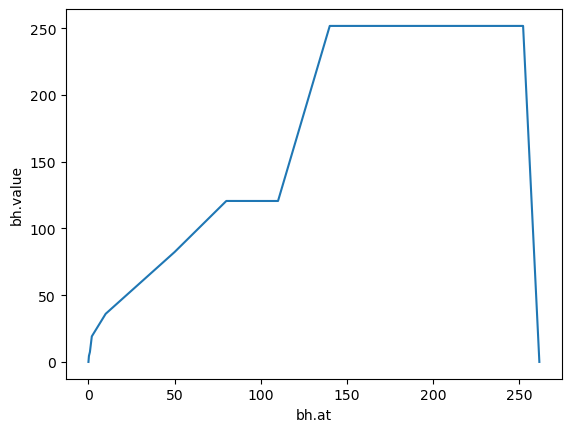

In [34]:
sns.lineplot(data=bh_df, x='bh.at', y='bh.value')

In [35]:
n = 'bwe'
k = [ { n: i } for i in sum([ i.get(n, []) for i in t_api_stats_qoe_pcap[1:] ], []) ]
bwe_df = pd.json_normalize(k)
bwe_df

,bwe.at,bwe.value
0,1.965,909374
1,0.009,752419
2,10.005,1684310
3,50.005,1277198
4,80.005,720374
5,110.005,924948
6,140.021,1541416
7,180.012,1541416
8,220.015,1541416
9,252.205,1541416


In [36]:
bwm_df['bwm.estimate'] = bwm_df['bwm.downloaded_bytes'] / bwm_df['bwm.seconds_to_download']

<AxesSubplot:xlabel='bwm.at', ylabel='bwm.estimate'>

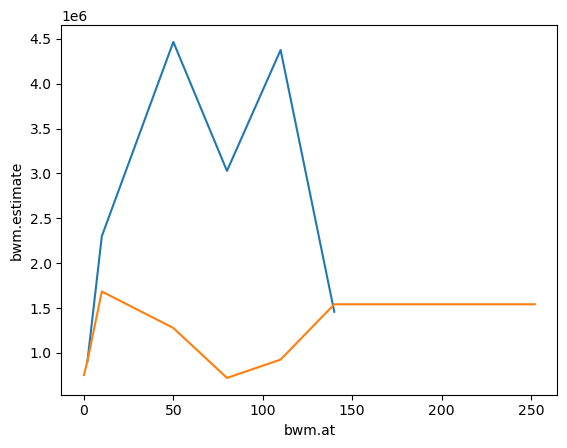

In [37]:
sns.lineplot(data=bwm_df, x='bwm.at', y='bwm.estimate')
sns.lineplot(data=bwe_df, x='bwe.at', y='bwe.value')